1. [Stationary streaming data](#section1)
2. [Non-stationary streaming data with seasonality / periodicity](#section2)
3. [Group-based anomaly detection in non-stationary streaming data](#section3)

In [1]:
# NOTE: run this cell before anything else
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from grand import IndividualAnomalyInductive, IndividualAnomalyTransductive, GroupAnomaly

<a id='section1'></a>
# 1. Stationary streaming data
Let's start with the simplest senario: a stationary data stream. The observations in a stationary data stream are not dependent on time; they are sampled iid from an unknown underlying distribution. The following is an example of a toy multivariate time series (two-features) which do not have trend or seasonal effects.

            Feature 0  Feature 1
Date                            
1959-01-01         35  20.835502
1959-01-02         32  19.059137
1959-01-03         30  21.119310
1959-01-04         31  12.945256
1959-01-05         44  29.281085


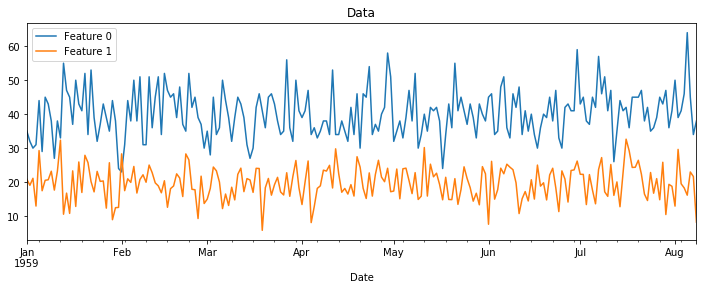

In [2]:
df0 = pd.read_csv('data/stationary-0.csv', header=0, index_col=0, parse_dates=True)
print(df0.head(5))

df0.plot(figsize=(12, 4), title="Data")
plt.show()

To look for anomalies in such a stationary data stream, we can create an anomaly detection model using the class `IndividualAnomalyInductive`. Then, we fit the model to a fixed reference dataset `X_fit` which is assumed to be normal (i.e. without anomalies). For example, `X_fit` can be the first $n$ samples from the data stream.

After running the following code, you will see that the deviation level is always low (close to 0) as long as the data continues to come from the same distribution as `X_fit`.

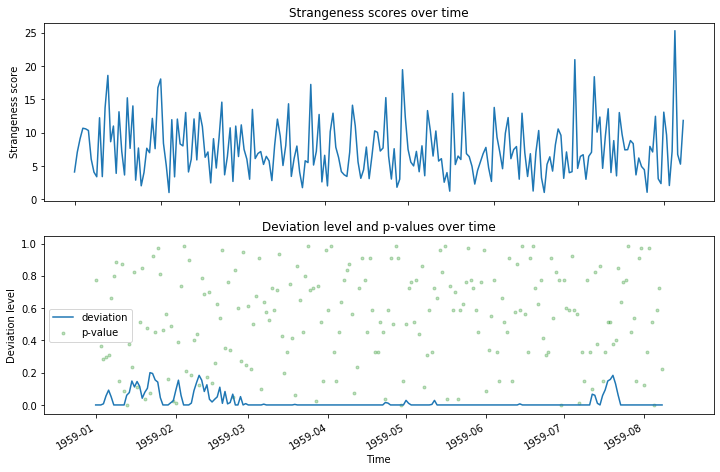

In [3]:
# Create a model using IndividualAnomalyInductive
model = IndividualAnomalyInductive(
            w_martingale = 15,          # Window size for computing the deviation level
            non_conformity = "median",  # Strangeness measure: "median" or "knn"
            k = 20                      # Used if non_conformity is "knn"
)


# Fit the model to a fixed subset of the data
X_fit = df0.head(n = 80).values
model.fit(X_fit)


# At each time step dt, a data-point x comes from the stream
for dt, x in zip(df0.index, df0.values):
    info = model.predict(dt, x)
    print("Time: {} ==> strangeness: {}, deviation: {}" .format(dt, info.strangeness, info.deviation), end="\r", flush=True)

# Plot strangeness and deviation level over time
model.plot_deviations(figsize=(12, 8))

## 1.1. Deviation due to a change in the data distribution
In the following dataset `stationary-1.csv`, a period of time (after August) is added where the data start to slowly deviate and come from a different distribution than `X_fit`.

After running the following code, you will notice that the deviation level increased significantly (indicating an anomaly) during the period where the change in the data distribution happened.

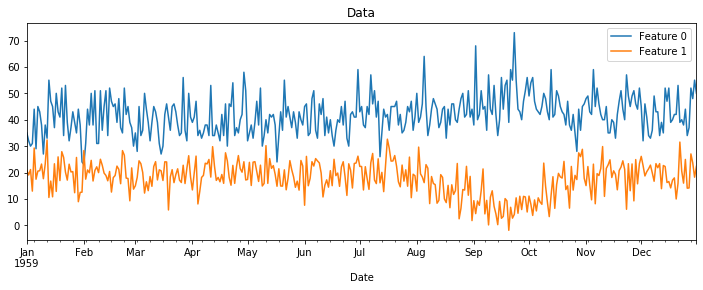

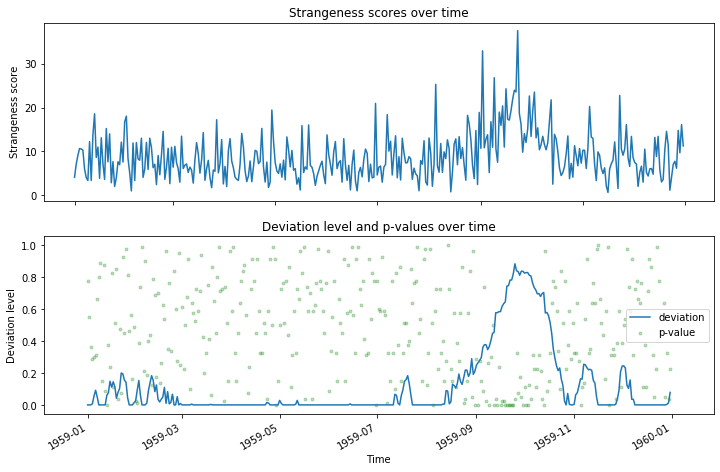

In [5]:
df1 = pd.read_csv('data/stationary-1.csv', header=0, index_col=0, parse_dates=True)
df1.plot(figsize=(12, 4), title="Data")
plt.show()

model = IndividualAnomalyInductive(w_martingale = 15, non_conformity = "median", k = 20)
model.fit(X_fit)

for dt, x in zip(df1.index, df1.values):
    info = model.predict(dt, x)
    print("Time: {} ==> strangeness: {}, deviation: {}" .format(dt, info.strangeness, info.deviation), end="\r", flush=True)

model.plot_deviations(figsize=(12, 8))

## 1.2. The effect of induvidual outliers on the deviation level
The following dataset `stationary-2.csv` shows the same data as the previous one, but with few individual outliers arround mid April.

After running this code, you will notice that such few individual outliers do not affect the deviation level as it is computed based on several consecutive samples from the stream. These outliers are however captured by the strangeness score, which is computed on individual samples from the stream.

The "strangeness score" reflects individual sample anoamlies, while the "deviation level" reflects collective anomalies or a consistent change over time in the data distribution.

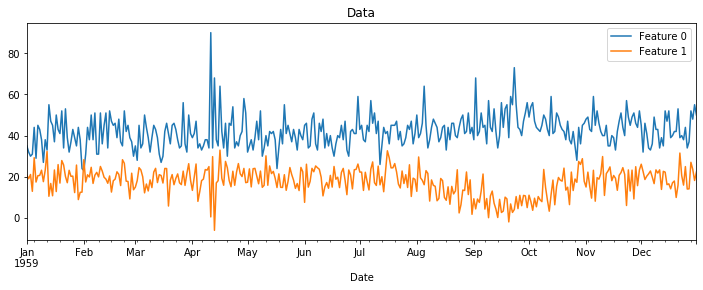

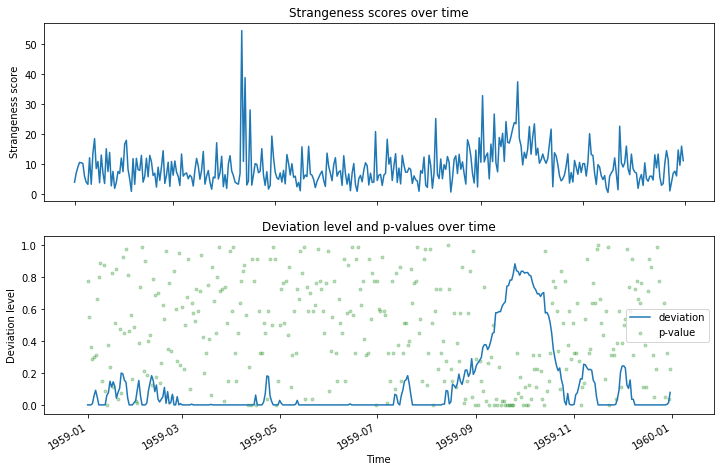

In [6]:
df2 = pd.read_csv('data/stationary-2.csv', header=0, index_col=0, parse_dates=True)
df2.plot(figsize=(12, 4), title="Data")
plt.show()

model = IndividualAnomalyInductive(w_martingale = 15, non_conformity = "median", k = 50)
model.fit(X_fit)

for dt, x in zip(df2.index, df2.values):
    info = model.predict(dt, x)
    print("Time: {} ==> strangeness: {}, deviation: {}" .format(dt, info.strangeness, info.deviation), end="\r", flush=True)

model.plot_deviations(figsize=(12, 8))

<a id='section2'></a>
# 2. Non-stationary streaming data with seasonality / periodicity
Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time.

## 2.1. Taxi passengers example
The following dataset `nyc_taxi.csv` consists of a univariate time series representing the number of NYC taxi passengers aggregated into 30 minute buckets (for 7 months of data). The plot below shows a subset of the data corresponding to the first two weeks of July (starting on Tuesday).

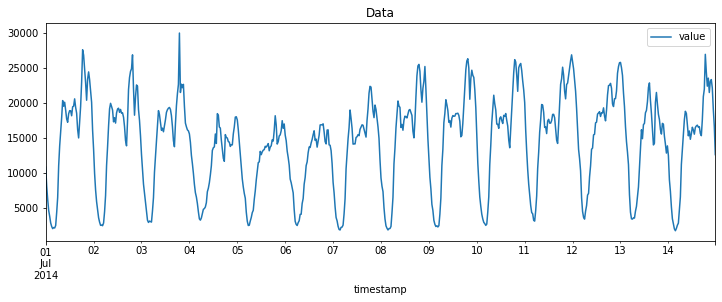

In [7]:
df = pd.read_csv('data/nyc_taxi.csv', header=0, index_col=0, parse_dates=True)

df.head(336*2).plot(figsize=(12, 4), title="Data")
plt.show()

This non-stationary dataset is however periodic as we see similar patterns repeating over days and weeks.

One way to look for anomalies in such data streams, we can create an anomaly detection model using the class `IndividualAnomalyTransductive`. This model takes a parameter `ref_group` specifying the criteria to use in orde to construct a reference dataset. Each time the `predict` function is called for a new sample `x` at time `t`, a reference dataset is constructed from historical data (prior to `t`) based on the criteria specified in `ref_group`.

The parameter `ref_group` takes one or more criteria from the following: `["hour-of-day", "day-of-week", "day-of-month", "week-of-year", "month-of-year", "season-of-year"]`. It can also be set to `ref_group = "external"` is one wants to specify its own criteria which doesn't necessarily depend on time (as we will see later).

In the code below, we have set `ref_group = ["hour-of-day", "day-of-week"]` for the Taxi dataset. This means that each new sample `x`, received at current time `t`, will be compared against historical samples where the *hour-of-the-day* was the same as the current hour and the *day-of-the-week* was the same as the current weekday.

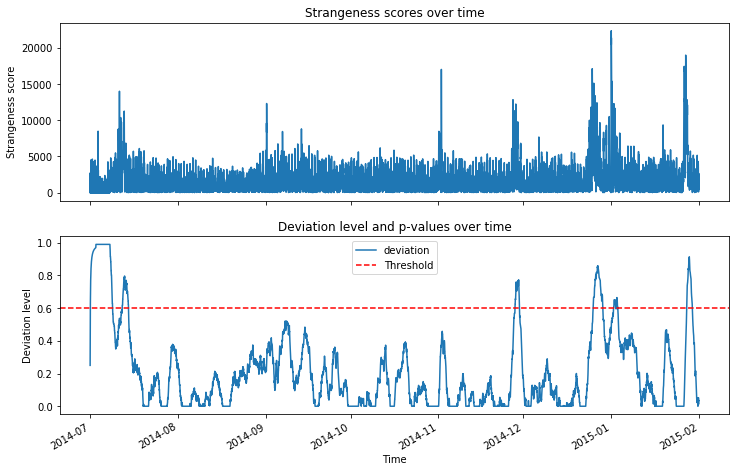

In [8]:
# Create a model using IndividualAnomalyTransductive
model = IndividualAnomalyTransductive(
            w_martingale = 100,          # Window size for computing the deviation level
            non_conformity = "median",  # Strangeness measure: "median" or "knn"
            k = 20,                     # Used if non_conformity is "knn"
            ref_group = ["hour-of-day", "day-of-week"]  # Criteria for reference group construction
)


# At each time step dt, a data-point x comes from the stream
for dt, x in zip(df.index, df.values):
    info = model.predict(dt, x)
    print("Time: {} ==> strangeness: {}, deviation: {}".format(dt, info.strangeness, info.deviation), end="\r")


# Plot strangeness and deviation level over time
model.plot_deviations(figsize=(12, 8))

The following code highlights periods where some events occured (e.g. the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm) that lead to a high anomaly score.

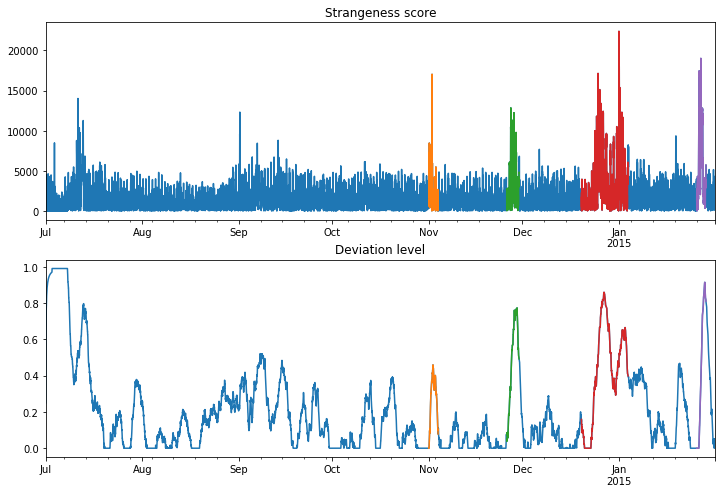

In [9]:
periods = [
    ("2014-11-01", "2014-11-03"),  # NY city Marathon on 2014-11-02
    ("2014-11-26", "2014-11-29"),  # Thanksgiving on 2014-11-27
    ("2014-12-20", "2015-01-03"),  # Christmas and new year
    ("2015-01-26", "2015-01-28")   # Bad weather (snow storm)
]

stats = model.get_stats()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
stats["strangeness"].plot(ax=ax1, title="Strangeness score")
stats["deviation"].plot(ax=ax2, title="Deviation level")
for frm, to in periods:
    stats[frm:to]["strangeness"].plot(ax=ax1)
    stats[frm:to]["deviation"].plot(ax=ax2)

plt.show()

## 2.2. Heatpumps data example
TODO: using external criteria such as outside temperature.

In [10]:
# TODO
CODE = None

The class `IndividualAnomalyTransductive` assumes that there is some kind of periodicity and that there is sufficient historical data to construct a reference dataset for each new sample.

However, it becomes not possible to use such model in the following when:
- The external conditions that affects the distribution of the data are unknown.
- Or, when there is no sufficient amount of historical data (e.g. seasonality happers over years).
- Or, when there is no periodicity in the data at all.

<a id='section3'></a>
# 3. Group-based anomaly detection in non-stationary streaming data

TODO